# <a id="top"></a>Intersecting model grids with shapes

_Note: This feature requires the shapely package (which is an optional FloPy dependency)._

This notebook shows the grid intersection functionality in flopy. The
intersection methods are available through the `GridIntersect` object. A flopy
modelgrid is passed to instantiate the object. Then the modelgrid can be
intersected with Points, LineStrings and Polygons and their Multi variants.

### Table of Contents
- [GridIntersect Class](#gridclass)
- [Rectangular regular grid](#rectgrid)
    - [Polygon with regular grid](#rectgrid.1)
    - [MultiLineString with regular grid](#rectgrid.2)
    - [MultiPoint with regular grid](#rectgrid.3)
- [Vertex grid](#trigrid)
    - [Polygon with triangular grid](#trigrid.1)
    - [MultiLineString with triangular grid](#trigrid.2)
    - [MultiPoint with triangular grid](#trigrid.3)

Import packages

In [1]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.geometry import (
    LineString,
    MultiLineString,
    MultiPoint,
    MultiPolygon,
    Point,
    Polygon,
)

import flopy
import flopy.discretization as fgrid
import flopy.plot as fplot
from flopy.utils import GridIntersect

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))
print("shapely version: {}".format(shapely.__version__))

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
numpy version: 1.24.1
matplotlib version: 3.6.3
flopy version: 3.3.7
shapely version: 2.0.0


## <a id="gridclass"></a>[GridIntersect Class](#top)

The GridIntersect class is constructed by passing a flopy modelgrid object to
the constructor. There are options users can select to change how the
intersection is calculated.

- `method`: derived from model grid type or defined by the user: can be either `"vertex"` or
`"structured"`. If `"structured"` is passed, the intersections are performed
using structured methods. These methods use information about the regular grid
to limit the search space for intersection calculations. Note that `method="vertex"` 
also works for structured grids.
- `rtree`: either `True` (default) or `False`, only read when
`method="vertex"`. When True, an STR-tree is built, which allows for fast
spatial queries. Building the STR-tree does take some time however. Setting the
option to False avoids building the STR-tree but requires the intersection
calculation to loop through all grid cells.

In general the "vertex" option is robust and fast and is therefore recommended
in most situations. In some rare cases building the STR-tree might not be worth
the time, in which case it can be avoided by passing `rtree=False`. If you are
working with a structured grid, then the `method="structured"` can speed up
intersection operations in some situations (e.g. for (multi)points) with the added
advantage of not having to build an STR-tree.

The important methods in the GridIntersect object are:

- `intersects()`: returns cellids for gridcells that intersect a shape (accepts
shapely geometry objects, flopy geometry object, shapefile.Shape objects, and
geojson objects)
- `intersect()`: for intersecting the modelgrid with point, linestrings, and
polygon geometries (accepts shapely geometry objects, flopy geometry object,
shapefile.Shape objects, and geojson objects)
- `plot_point()`: for plotting point intersection results
- `plot_linestring()`: for plotting linestring intersection results
- `plot_polygon()`: for plotting polygon intersection results

In the following sections examples of intersections are shown for structured
and vertex grids for different types of shapes (Polygon, LineString and Point).

## <a id="rectgrid"></a>[Rectangular regular grid](#top)

In [2]:
delc = 10 * np.ones(10, dtype=float)
delr = 10 * np.ones(10, dtype=float)

In [3]:
xoff = 0.0
yoff = 0.0
angrot = 0.0
sgr = fgrid.StructuredGrid(
    delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff, angrot=angrot
)

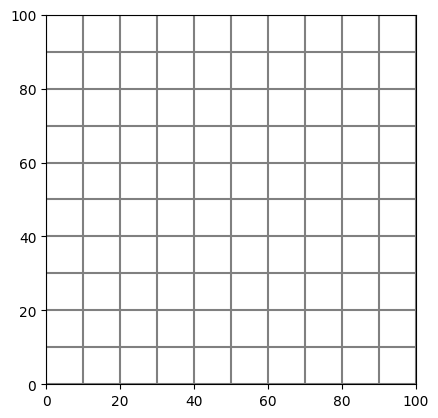

In [4]:
sgr.plot();

### <a id="rectgrid.1"></a>[Polygon with regular grid](#top)
Polygon to intersect with:

In [5]:
p = Polygon(
    shell=[
        (15, 15),
        (20, 50),
        (35, 80.0),
        (80, 50),
        (80, 40),
        (40, 5),
        (15, 12),
    ],
    holes=[[(25, 25), (25, 45), (45, 45), (45, 25)]],
)

Create the GridIntersect class for our modelgrid. The `method` kwarg is passed to force GridIntersect to use the `"vertex"` intersection methods.

In [6]:
ix = GridIntersect(sgr, method="vertex")

Do the intersect operation for a polygon

In [7]:
result = ix.intersect(p)

The results are returned as a numpy.recarray containing several fields based on the intersection performed. An explanation of the data in each of the possible fields is given below:
- **cellids**: contains the cell ids of the intersected grid cells
- **vertices**: contains the vertices of the intersected shape
- **areas**: contains the area of the polygon in that grid cell (only for polygons)
- **lengths**: contains the length of the linestring in that grid cell (only for linestrings)
- **ixshapes**: contains the shapely object representing the intersected shape (useful for plotting the result)

Looking at the first few entries of the results of the polygon intersection (convert to pandas.DataFrame for prettier formatting)

In [8]:
result[:5]
# pd.DataFrame(result)  # recommended for prettier formatting and working with result

rec.array([((2, 3), <POLYGON ((35 80, 40 76.667, 40 70, 30 70, 35 80))>,  66.66666667),
           ((2, 4), <POLYGON ((50 70, 40 70, 40 76.667, 50 70))>,  33.33333333),
           ((3, 2), <POLYGON ((30 70, 30 60, 25 60, 30 70))>,  25.        ),
           ((3, 3), <POLYGON ((40 70, 40 60, 30 60, 30 70, 40 70))>, 100.        ),
           ((3, 4), <POLYGON ((50 70, 50 60, 40 60, 40 70, 50 70))>, 100.        )],
          dtype=[('cellids', 'O'), ('ixshapes', 'O'), ('areas', '<f8')])

The cellids can be easily obtained 

In [9]:
result.cellids

array([(2, 3), (2, 4), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 2),
       (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 1), (5, 2), (5, 3),
       (5, 4), (5, 5), (5, 6), (5, 7), (6, 1), (6, 2), (6, 4), (6, 5),
       (6, 6), (6, 7), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6),
       (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 2), (9, 3), (9, 4)],
      dtype=object)

Or the areas

In [10]:
result.areas

array([ 66.66666667,  33.33333333,  25.        , 100.        ,
       100.        ,  66.66666667,   8.33333333,  75.        ,
       100.        , 100.        , 100.        ,  91.66666667,
        33.33333333,   7.14285714,  75.        ,  50.        ,
        75.        , 100.        , 100.        , 100.        ,
        21.42857143,  50.        ,  50.        , 100.        ,
        99.10714286,  43.75      ,  35.71428571,  75.        ,
        50.        ,  75.        ,  96.42857143,  32.14285714,
        41.71428571,  99.35714286, 100.        ,  91.96428571,
        22.32142857,   8.64285714,  36.        ,  14.28571429])

If  a user is only interested in which cells the shape intersects (and not the areas or the actual shape of the intersected object) with there is also the `intersects()` method. This method works for all types of shapely geometries.

In [11]:
ix.intersects(p)

rec.array([((8, 1),), ((7, 2),), ((7, 1),), ((6, 1),), ((6, 2),),
           ((9, 4),), ((9, 2),), ((9, 3),), ((8, 2),), ((8, 3),),
           ((8, 4),), ((7, 3),), ((7, 4),), ((6, 4),), ((5, 1),),
           ((4, 1),), ((4, 2),), ((3, 2),), ((5, 2),), ((5, 3),),
           ((5, 4),), ((4, 3),), ((4, 4),), ((3, 4),), ((3, 3),),
           ((2, 4),), ((2, 3),), ((2, 2),), ((1, 3),), ((8, 5),),
           ((7, 5),), ((7, 6),), ((6, 5),), ((6, 6),), ((6, 7),),
           ((6, 8),), ((5, 5),), ((5, 7),), ((5, 6),), ((4, 6),),
           ((4, 5),), ((3, 6),), ((3, 5),), ((2, 5),), ((5, 8),),
           ((4, 8),), ((4, 7),)],
          dtype=[('cellids', 'O')])

The results of an intersection can be visualized with the plotting methods in the `GridIntersect` object:
- `plot_polygon`
- `plot_linestring`
- `plot_point`

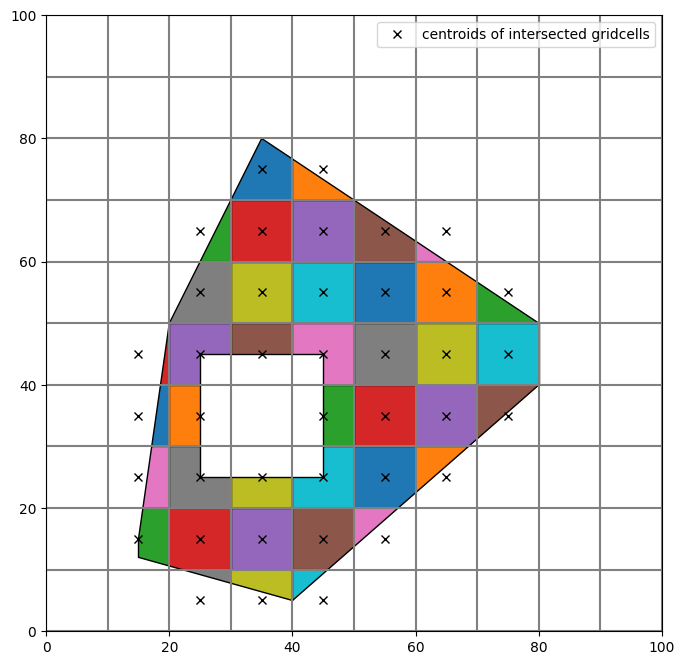

In [12]:
# create a figure and plot the grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

# the intersection object contains some helpful plotting commands
ix.plot_polygon(result, ax=ax)

# add black x at cell centers
for irow, icol in result.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="centroids of intersected gridcells",
    )

# add legend
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

The `intersect()` method contains several keyword arguments that specifically deal with polygons:

- `contains_centroid`: only store intersection result if cell centroid is contained within polygon
- `min_area_fraction`: minimal intersecting cell area (expressed as a fraction of the total cell area) to include cells in intersection result

Two examples showing the usage of these keyword arguments are shown below.

Example with `contains_centroid` set to True, only cells in which centroid is within the intersected polygon are stored. Note the difference with the previous result.

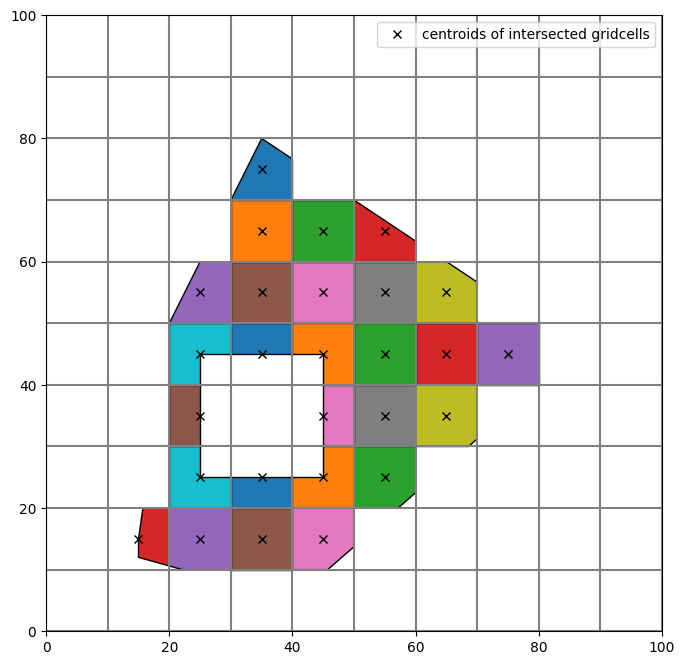

In [13]:
# contains_centroid example

result2 = ix.intersect(p, contains_centroid=True)

# create a figure and plot the grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

# the intersection object contains some helpful plotting commands
ix.plot_polygon(result2, ax=ax)

# add black x at cell centers
for irow, icol in result2.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="centroids of intersected gridcells",
    )

# add legend
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

Example with `min_area_threshold` set to 0.35, the intersection result in a cell should cover 35% or more of the cell area.

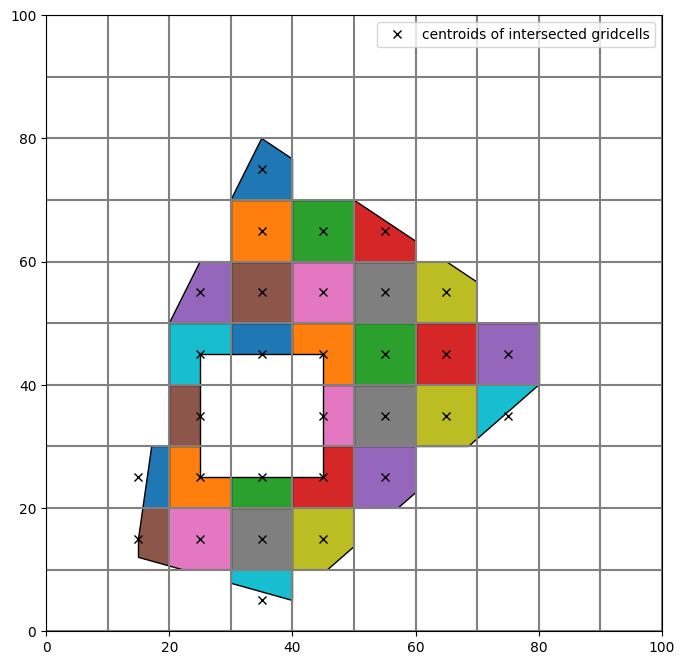

In [14]:
# min_area_threshold example

result3 = ix.intersect(p, min_area_fraction=0.35)

# create a figure and plot the grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

# the intersection object contains some helpful plotting commands
ix.plot_polygon(result3, ax=ax)

# add black x at cell centers
for irow, icol in result3.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="centroids of intersected gridcells",
    )

# add legend
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

Alternatively, the intersection can be calculated using special methods optimized for structured grids. Access these methods by instantiating the GridIntersect class with the `method="structured"` keyword argument.

In [15]:
ixs = GridIntersect(sgr, method="structured")
result4 = ixs.intersect(p)

The result is the same as before:

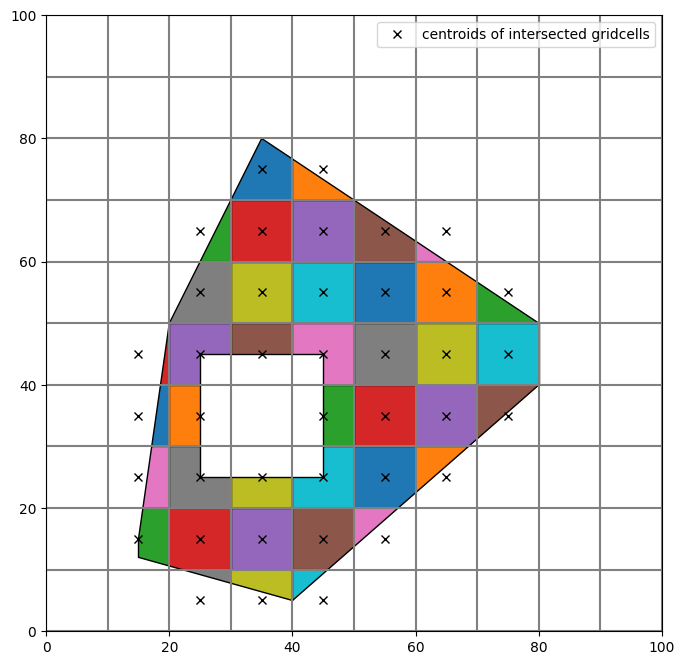

In [16]:
# create a figure and plot the grid
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)

# the intersection object contains some helpful plotting commands
ix.plot_polygon(result4, ax=ax)

# add black x at cell centers
for irow, icol in result4.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="centroids of intersected gridcells",
    )

# add legend
ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

### <a id="rectgrid.2"></a>[Polyline with regular grid](#top)
MultiLineString to intersect with:

In [17]:
ls1 = LineString([(95, 105), (30, 50)])
ls2 = LineString([(30, 50), (90, 22)])
ls3 = LineString([(90, 22), (0, 0)])
mls = MultiLineString(lines=[ls1, ls2, ls3])

In [18]:
result = ix.intersect(mls)

Plot the result

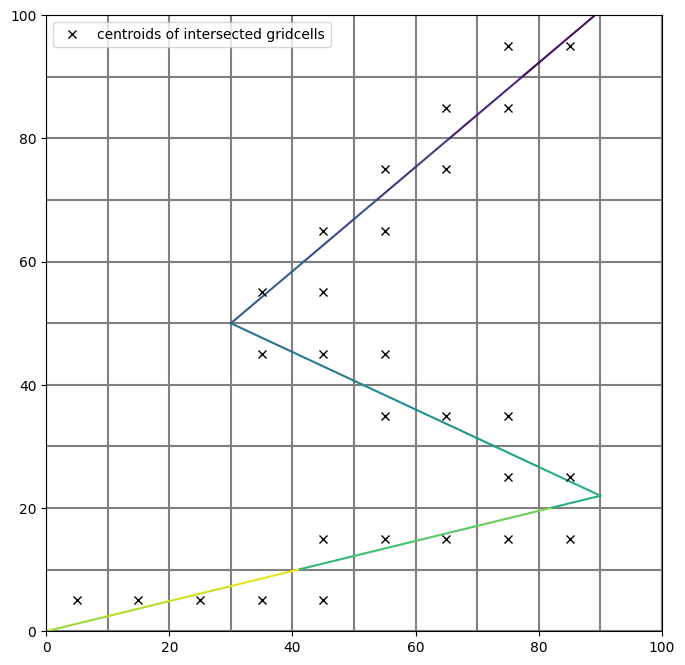

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_linestring(result, ax=ax, cmap="viridis")

for irow, icol in result.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

Same as before, the intersect for structured grids can also be performed with a different method optimized for structured grids

In [20]:
ixs = GridIntersect(sgr, method="structured")

In [21]:
result2 = ixs.intersect(mls)

# ordering is different so compare sets to check equality
check = len(set(result2.cellids) - set(result.cellids)) == 0
print(
    "Intersection result with method='structured' and "
    f"method='vertex' are equal: {check}"
)

Intersection result with method='structured' and method='vertex' are equal: True


### [MultiPoint with regular grid](#top)<a id="rectgrid.3"></a>

MultiPoint to intersect with

In [22]:
mp = MultiPoint(
    points=[
        Point(50.0, 0.0),
        Point(45.0, 45.0),
        Point(10.0, 10.0),
        Point(150.0, 100.0),
    ]
)

For points and linestrings there is a keyword argument `return_all_intersections` which will return multiple intersection results for points or (parts of) linestrings on cell boundaries. As an example, the difference is shown with the MultiPoint intersection. Note the number of red "+" symbols indicating the centroids of intersected cells, in the bottom left case, there are 4 results because the point lies exactly on the intersection between 4 grid cells. 

In [23]:
result = ix.intersect(mp)
result_all = ix.intersect(mp, return_all_intersections=True)

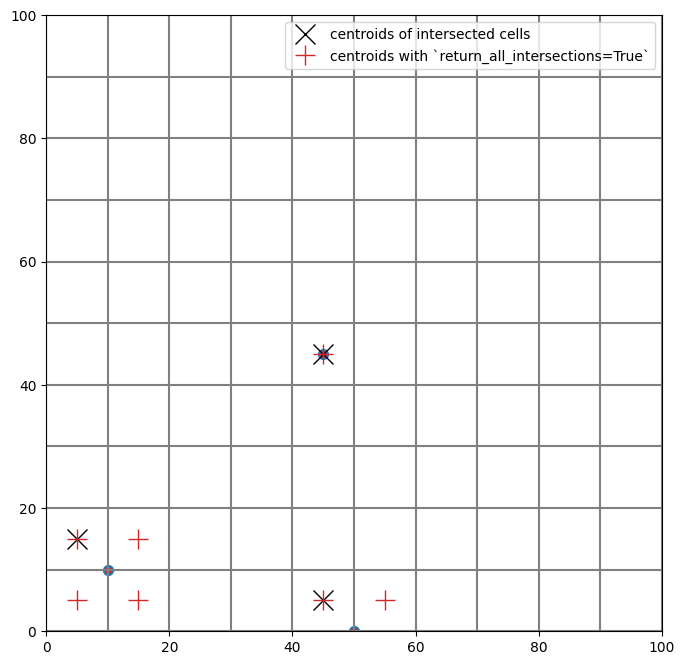

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sgr.plot(ax=ax)
ix.plot_point(result, ax=ax, s=50, color="C0")
ix.plot_point(result_all, ax=ax, s=50, marker=".", color="C3")

for irow, icol in result.cellids:
    (h2,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "kx",
        ms=15,
        label="centroids of intersected cells",
    )

for irow, icol in result_all.cellids:
    (h3,) = ax.plot(
        sgr.xcellcenters[0, icol],
        sgr.ycellcenters[irow, 0],
        "C3+",
        ms=15,
        label="centroids with `return_all_intersections=True`",
    )

ax.legend([h2, h3], [i.get_label() for i in [h2, h3]], loc="best");

Same as before, the intersect for structured grids can also be performed with a different method written specifically for structured grids.

In [25]:
ixs = GridIntersect(sgr, method="structured")

In [26]:
result2 = ixs.intersect(mp, return_all_intersections=False)

# ordering is different so compare sets to check equality
check = len(set(result2.cellids) - set(result.cellids)) == 0
print(
    "Intersection result with method='structured' and "
    f"method='vertex' are equal: {check}"
)

Intersection result with method='structured' and method='vertex' are equal: True


## <a id="trigrid"></a>[Vertex Grid](#top)

In [27]:
cell2d = [
    [0, 83.33333333333333, 66.66666666666667, 3, 4, 2, 7],
    [1, 16.666666666666668, 33.333333333333336, 3, 4, 0, 5],
    [2, 33.333333333333336, 83.33333333333333, 3, 1, 8, 4],
    [3, 16.666666666666668, 66.66666666666667, 3, 5, 1, 4],
    [4, 33.333333333333336, 16.666666666666668, 3, 6, 0, 4],
    [5, 66.66666666666667, 16.666666666666668, 3, 4, 3, 6],
    [6, 83.33333333333333, 33.333333333333336, 3, 7, 3, 4],
    [7, 66.66666666666667, 83.33333333333333, 3, 8, 2, 4],
]
vertices = [
    [0, 0.0, 0.0],
    [1, 0.0, 100.0],
    [2, 100.0, 100.0],
    [3, 100.0, 0.0],
    [4, 50.0, 50.0],
    [5, 0.0, 50.0],
    [6, 50.0, 0.0],
    [7, 100.0, 50.0],
    [8, 50.0, 100.0],
]
tgr = fgrid.VertexGrid(vertices, cell2d)

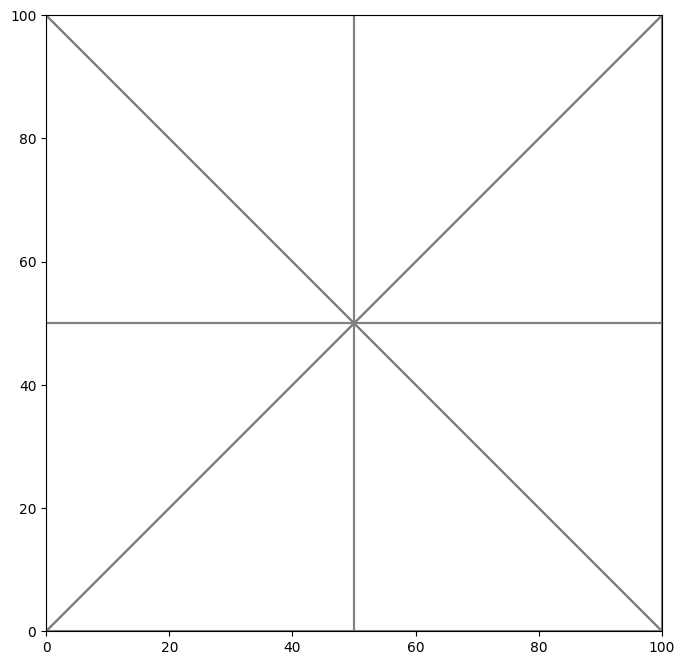

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(modelgrid=tgr)
pmv.plot_grid(ax=ax);

### <a id="trigrid.1"></a>[Polygon with triangular grid](#top)

In [29]:
ix2 = GridIntersect(tgr)

In [30]:
result = ix2.intersect(p)

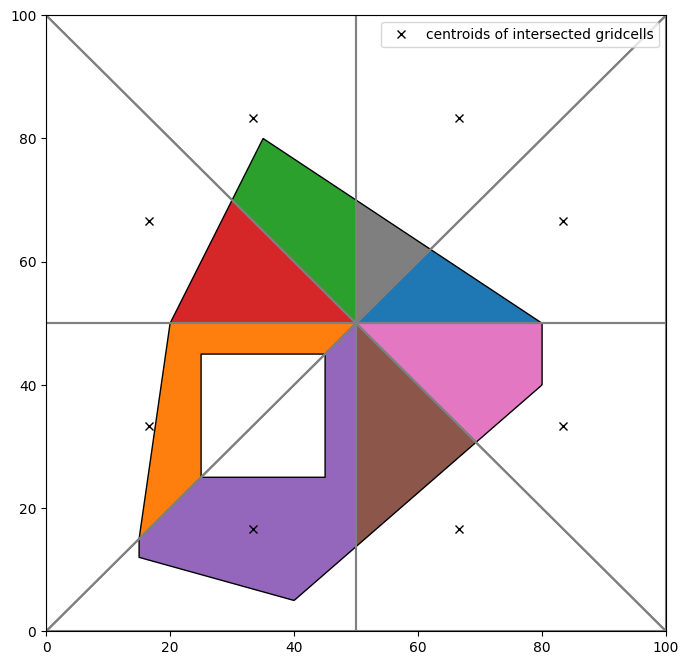

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix.plot_polygon(result, ax=ax)

# only cells that intersect with shape
for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

### <a id="trigrid.2"></a>[LineString with triangular grid](#top)

In [32]:
result = ix2.intersect(mls)

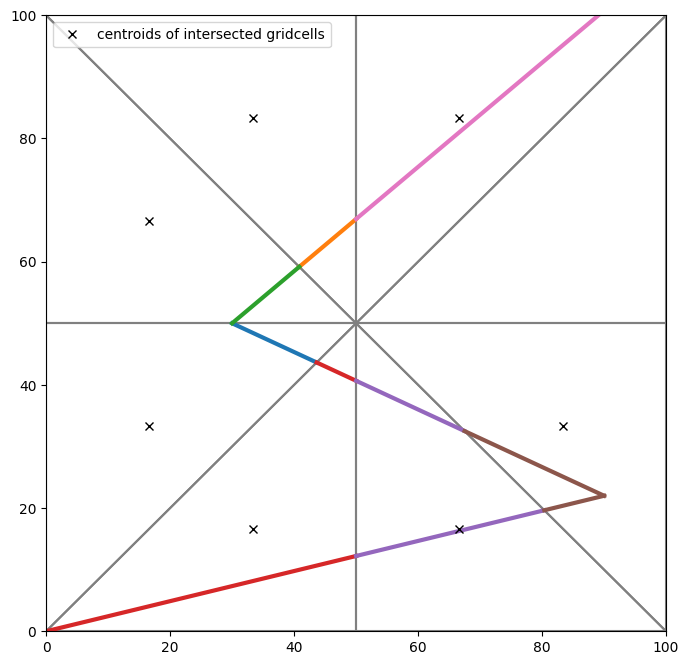

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_linestring(result, ax=ax, lw=3)

for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "kx",
        label="centroids of intersected gridcells",
    )

ax.legend([h2], [i.get_label() for i in [h2]], loc="best");

### <a id="trigrid.3"></a>[MultiPoint with triangular grid](#top)

In [34]:
result = ix2.intersect(mp)
result_all = ix2.intersect(mp, return_all_intersections=True)

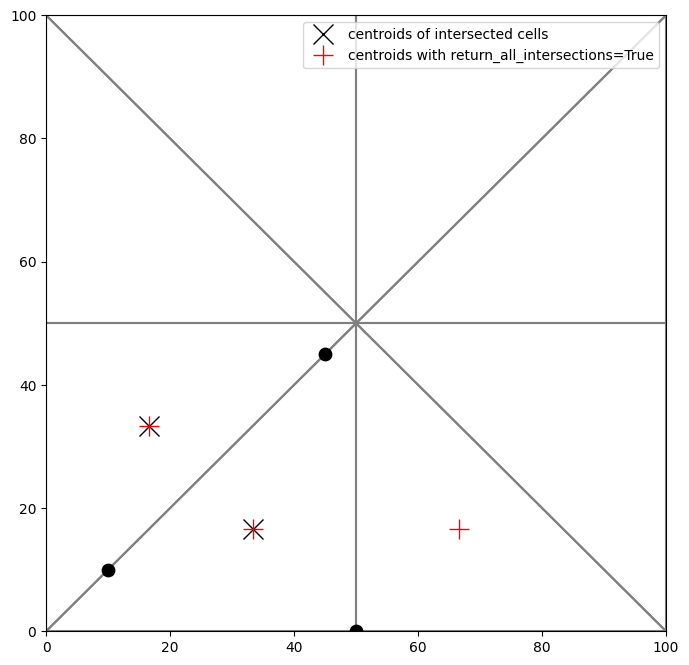

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
pmv = fplot.PlotMapView(ax=ax, modelgrid=tgr)
pmv.plot_grid()
ix2.plot_point(result, ax=ax, color="k", zorder=5, s=80)

for cellid in result.cellids:
    (h2,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "kx",
        ms=15,
        label="centroids of intersected cells",
    )
for cellid in result_all.cellids:
    (h3,) = ax.plot(
        tgr.xcellcenters[cellid],
        tgr.ycellcenters[cellid],
        "r+",
        ms=15,
        label="centroids with return_all_intersections=True",
    )

ax.legend([h2, h3], [i.get_label() for i in [h2, h3]], loc="best");